# Implémentation d'un CNN pour une classification d'images en genre Female ou Male

In [ ]:
##  Importation des modules

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications.mobilenet import MobileNet ,preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [11]:
#!pip install kagglehub

# Collecte et Exploration des données

In [32]:
import kagglehub

# Download latest version
#path = kagglehub.dataset_download("ashishjangra27/gender-recognition-200k-images-celeba")
dataset_path ="C:/Users/kesse/.cache/kagglehub/datasets/ashishjangra27/gender-recognition-200k-images-celeba/versions/1/Dataset"
#print("Path to dataset files:", path)

Shape d'une image : (178, 218)


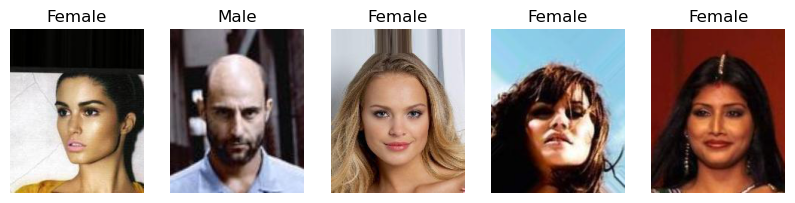

In [42]:
from PIL import Image

#dataset_path = os.path.join(path, 'Dataset')
# Fonction pour afficher quelques images
def plot_sample_images(data_path, n=5):
    plt.figure(figsize=(10, 5))
    for i in range(n):
        plt.subplot(1, 5, i+1)
        gender = random.choice(['Female', 'Male'])
        img_path = os.path.join(data_path, 'Train', gender, random.choice(os.listdir(os.path.join(data_path, 'Train', gender))))
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.title(gender)
        plt.axis('off')
        
    image_path = os.path.join(data_path, 'Train', gender, random.choice(os.listdir(os.path.join(data_path, 'Train', gender))))
    image = Image.open(image_path)
    print(f"Shape d'une image : {image.size}")
    plt.show()

plot_sample_images(dataset_path, n=5)

In [9]:
total_images = sum([len(files) for r, d, files in os.walk(dataset_path)])
print('Total des images du dataset : ',total_images)

Total des images du dataset :  202599


* Remarques : Dimensions Variables : Les dimensions des images (178,218) ne sont pas uniformes. Cela peut poser des problèmes lors de l'entraînement d'un modèle, car les réseaux de neurones nécessitent des entrées de taille fixe.

## Organisation des données en set de train, test et validation avec des scripts Python

In [ ]:
#2e méthode pour charger les données
import os
import shutil
import random

# Chemin vers le dossier contenant les images
male_train_dir = os.path.join(dataset_path, 'Train' , 'Male')
male_test_dir = os.path.join(dataset_path, 'Test', 'Male')
male_val_dir = os.path.join(dataset_path, 'Validation', 'Male')

female_train_dir = os.path.join(dataset_path, 'Train', 'Female')
female_test_dir = os.path.join(dataset_path, 'Test', 'Female')
female_val_dir = os.path.join(dataset_path, 'Validation', 'Female')

# Initialiser les listes pour les images et les labels
x_train, y_train = [], []
x_val, y_val = [], []
x_test, y_test = [], []

# Fonction pour charger les images et les labels
def load_data(directory, x_list, y_list, label):
    for filename in os.listdir(directory): 
        if filename.endswith(('.png', '.jpg', '.jpeg')): 
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path).resize(32,32)
            x_list.append(np.array(img)) 
            y_list.append(label) 


load_data(female_train_dir, x_train, y_train, 1)
load_data(male_train_dir, x_train, y_train, 0)

print(x_train[:2], y_train[:2])

In [58]:
load_data(female_test_dir, x_test, y_test, 1)
load_data(male_test_dir, x_test, y_test, 0)

load_data(female_val_dir, x_val, y_val, 1)
load_data(male_val_dir, x_val, y_val, 0)

In [60]:
# Prétraitement avec la 2e méthode de récupération des data

# Normalisation des données
x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

# Conversion des labels en format numérique
#y_train = np.array([1 if label == 'Female' else 0 for label in y_train])
#y_val = np.array([1 if label == 'Female' else 0 for label in y_val])
#y_test = np.array([1 if label == 'Female' else 0 for label in y_test])

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Ajuster le générateur de données sur les données d'entraînement
#datagen.fit(x_train)

MemoryError: Unable to allocate 58.6 GiB for an array with shape (160000, 128, 128, 3) and data type float64

# Pré-traitement

## Organisation des données de train, test et val avec ImageDataGenerator de TF

In [49]:
# Création des générateurs d'images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Chargement des données
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, 'Train'),
    target_size=(32, 32),  # Redimensionnez selon vos besoins
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(dataset_path, 'Validation'),
    target_size=(32, 32),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'Test'),
    target_size=(32, 32),
    batch_size=32,
    class_mode='binary'
)

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.
Found 20001 images belonging to 2 classes.


ImageDataGenerator : Une classe de Keras qui génère des lots d'images en temps réel avec des augmentations de données.

Transformation :
* rescale=1./255 : Normalise les valeurs des pixels d'images de [0, 255] à [0, 1].
* rotation_range=20 : Permet une rotation aléatoire des images jusqu'à 20 degrés.
* width_shift_range=0.2 : Décale aléatoirement les images horizontalement jusqu'à 20% de la largeur.
* height_shift_range=0.2 : Décale aléatoirement les images verticalement jusqu'à 20% de la hauteur.
* shear_range=0.2 : Applique une transformation de cisaillement (shear) jusqu'à 20%.
* zoom_range=0.2 : Permet un zoom aléatoire jusqu'à 20%.
* horizontal_flip=True : Permet de retourner les images horizontalement.
* fill_mode='nearest' : Remplit les pixels vides après transformation avec la valeur des pixels les plus proches.

flow_from_directory(...) : Charge les images à partir d'un répertoire, en les étiquetant automatiquement en fonction des noms de sous-dossiers.
os.path.join(dataset_path, 'Training') : Donne le chemin du dossier d'entraînement.
target_size=(128, 128) : Redimensionne toutes les images à 128x128 pixels.
batch_size=32 : Définit la taille des lots d'images (32 images par lot).
class_mode='binary' : Indique  une classification binaire 

## Explorations et Visualisation post_transformation 

In [17]:
batch_images, batch_labels = next(train_generator)

# Vérifier la forme des images et des labels
print(f"Shape des images dans le lot : {batch_images.shape}")  # (batch_size, 128, 128, 3)
print(f"Shape des labels dans le lot : {batch_labels.shape}")  # (batch_size,)
print(len(batch_images))

Shape des images dans le lot : (32, 32, 32, 3)
Shape des labels dans le lot : (32,)
32


[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1.
 0. 0. 1. 1. 0. 0. 0. 0.],[0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1.
 0. 0. 1. 0. 1. 0. 0. 0.],[1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1.
 1. 1. 0. 0. 0. 0. 0. 1.],[0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 1. 1.],[0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 1. 0. 0. 1. 1.],

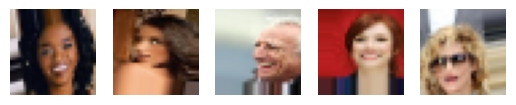

In [19]:

def visualize_augmentations(generator, n=5):
    for i in range(n):
        img, label = next(generator)
        plt.subplot(1, n, i + 1)
        plt.imshow(img[0])  # Affiche la première image du lot
        plt.axis('off')
        print(label, end =',')
    plt.show()

visualize_augmentations(train_generator)

# Modélisation

In [51]:
# ==============================================================
# 2. Construction du modèle CNN
# ==============================================================
# Le modèle Sequential permet d'empiler les couches simplement
model = Sequential()

# Première couche de convolution
model.add(Conv2D(
    filters=32,                  # Nombre de filtres (ou noyaux) pour détecter les caractéristiques
    kernel_size=(3, 3),          # Taille des filtres (matrice 3x3)
    activation='relu',           # Fonction d'activation (ReLU introduit la non-linéarité)
    padding='same',              # Padding 'same' conserve la taille d'entrée après convolution
    input_shape=(32, 32, 3)      # Forme des images d'entrée : 128x128 pixels, 3 canaux (RGB)
))

# Première couche de pooling (réduction de dimension)
model.add(MaxPooling2D(
    pool_size=(2, 2)             # Réduit la taille de l'image de moitié (2x2)
))

# Deuxième couche de convolution
model.add(Conv2D(
    filters=64,
    kernel_size=(3, 3),
    activation='relu',
    padding='same'
))

# Deuxième couche de pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# Troisième couche de convolution
model.add(Conv2D(
    filters=128,
    kernel_size=(3, 3),
    activation='relu',
    padding='same'
))

# Troisième couche de pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplatissement des matrices en un vecteur pour connecter aux couches denses
model.add(Flatten())

# Première couche dense avec 128 neurones
model.add(Dense(
    units=128,                   # Nombre de neurones dans la couche dense
    activation='relu'            # Fonction d'activation ReLU
))

# Dropout pour réduire le surapprentissage
model.add(Dropout(
    rate=0.25                     # Désactive 25% des neurones de manière aléatoire pendant l'entraînement
))

# Couche de sortie avec 10 neurones (une pour chaque classe)
model.add(Dense(
    units=1,                    # Nombre de classes
    activation='sigmoid'         # Softmax pour multiclass et sigmoid pour 2 classes
))

Filtres : Si les images sont très variées (par exemple, différentes tailles, couleurs, etc.), on voudra peut-être utiliser un plus grand nombre de filtres dans les premières couches pour capturer plus de caractéristiques.

Couches : Si les images sont relativement simples, un modèle moins profond pourrait suffire. En revanche, pour des images plus complexes, vous pourriez avoir besoin de plus de couches pour extraire des caractéristiques plus abstraites.

Batch Size : Un batch size plus petit permet de mieux généraliser le modèle, mais augmente le temps d'entraînement. Un batch size trop grand peut entraîner une utilisation excessive de la mémoire. L'exploration des performances du modèle avec différents batch sizes peut aider à trouver le bon équilibre.

Sequential : Modèle de Keras qui permet d'empiler des couches de manière linéaire.
Conv2D : Couche de convolution 2D, utilisée pour extraire des caractéristiques des images.
MaxPooling2D : Couche de sous-échantillonnage qui réduit la dimensionnalité des images.
Flatten : Aplatie les données pour les passer à une couche dense.
Dense : Couche entièrement connectée.
Dropout : Couche qui désactive aléatoirement une fraction des neurones pendant l'entraînement pour éviter le surapprentissage.

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,649 (1.36 MB)

 Trainable params: 355,649 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# ==============================================================
# 3. Compilation du modèle
# ==============================================================
model.compile(
    optimizer='adam',            # Optimiseur adaptatif très utilisé, performant
    loss='binary_crossentropy', # Fonction de perte pour la classification multiclasse
    metrics=['accuracy']         # Mesure la précision comme métrique de performance
)

## Entrainement du modèle

In [59]:
# ==============================================================
# 4. Entraînement du modèle
# ==============================================================
# Early stopping : arrêt anticipé si la performance de validation ne s'améliore plus
early_stopping = EarlyStopping(
    monitor='val_loss',          # Surveille la perte sur les données de validation
    patience=3,                  # Arrête si aucune amélioration après 3 époques
    restore_best_weights=True    # Restaure les meilleurs poids observés
)

# Entraînement du modèle
history = model.fit(
    train_generator,            # Données d'entraînement
    epochs=5,                   # Nombre maximal d'époques
    batch_size=64, # Nombre d'images utilisées avant la mise à jour des poids
    validation_data=val_generator,        # 20% des données d'entraînement utilisées pour la validation
    callbacks=[early_stopping]   # Ajout de l'arrêt anticipé
)

Epoch 1/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 367s 73ms/step - accuracy: 0.7799 - loss: 0.4567 - val_accuracy: 0.9171 - val_loss: 0.1982
Epoch 2/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 368s 74ms/step - accuracy: 0.8965 - loss: 0.2450 - val_accuracy: 0.9246 - val_loss: 0.1862
Epoch 3/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 292s 58ms/step - accuracy: 0.9122 - loss: 0.2110 - val_accuracy: 0.9401 - val_loss: 0.1447
Epoch 4/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 256s 51ms/step - accuracy: 0.9181 - loss: 0.1983 - val_accuracy: 0.9400 - val_loss: 0.1434
Epoch 5/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 248s 50ms/step - accuracy: 0.9237 - loss: 0.1866 - val_accuracy: 0.9410 - val_loss: 0.1461


Remarques : 
* Si la val_loss stagne alors il y a un souci au niveau de la structure des données ou de l'architecture, le modèle n'apprend plus, ça ne sert à rien de continuer.
* The accuracy up there is the ttraining accuracy, when this training accuracy is too high and the test accuracy is so low then we can assume an overfitting

# Evaluation des performances du modèle

In [61]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nPrécision sur les données de test : {test_accuracy * 100:.2f}%")

626/626 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.9453 - loss: 0.1322

Précision sur les données de test : 94.83%


In [69]:
#===================================================================
# CLASSIFICATION REPORT
#===================================================================
# Récupérer les images et les labels à partir du test_generator
x_test1, y_test1 = next(test_generator)

# Prédictions du modèle
test_pred = model.predict(x_test1)  
y_pred = np.round(test_pred).astype(int) 

# Générer le rapport de classification
print(classification_report(y_test1, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94        18
         1.0       0.88      1.00      0.93        14

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.95      0.94      0.94        32



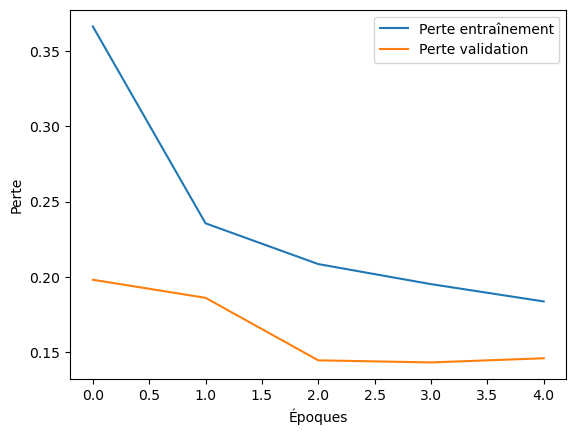

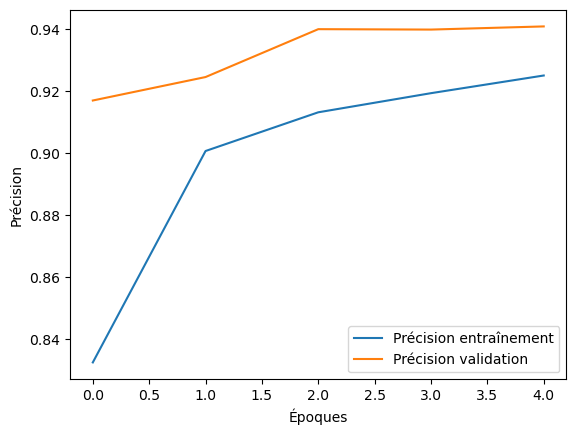

In [63]:
# ==============================================================
# 6. Visualisation des performances
# ==============================================================
# Courbe de perte
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.show()

# Courbe de précision
plt.plot(history.history['accuracy'], label='Précision entraînement')
plt.plot(history.history['val_accuracy'], label='Précision validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.show()

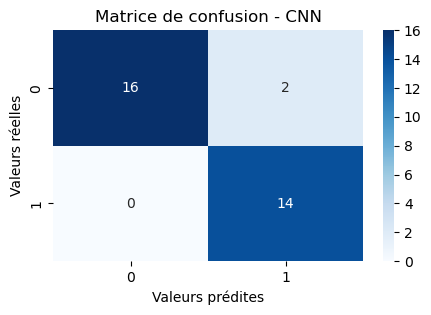

In [77]:
import seaborn as sns

plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix(y_test1, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.title("Matrice de confusion - CNN")
plt.show()

(32, 32)


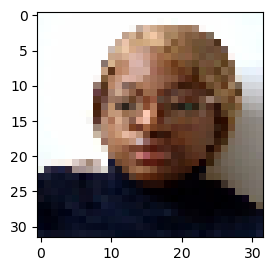

In [169]:
# ==============================================================
# Tests sur de nouvelles images
# ==============================================================

new_image_path = "C:/Users/kesse/Pictures/WIN_20250314_09_16_55_Pro.jpg"

img = Image.open(new_image_path).resize((32, 32), resample=Image.NEAREST)
plt.subplot(121)
plt.imshow(img)
print(img.size)

In [171]:
img_norm = np.array(img)/ 255.0
img_norm = np.expand_dims(img_norm, axis=0)
prediction = np.round(model.predict(img_norm)).astype(int) 
print(prediction) # [1] Je lui ai donné une de mes photos et encore heureux qu'il ait prédit "Female" :))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
[[1]]
